# Sarcasm and Sentiment Analysis in Turkish Political Discussions

This notebook is part of a larger project that aims to analyze the evolution of public discourse on Turkish politics, with a particular focus on the sarcasm analysis directed toward key political figures such as Recep Tayyip Erdoğan and Kemal Kılıçdaroğlu. By leveraging textual data from Ekşi Sözlük, this notebook outlines the steps for preprocessing the data and implementing a sarcasm detection model based on BERT architecture. The goal is to fine-tune the model to accurately identify sarcastic remarks, which are critical for a nuanced understanding of public sentiment. This work contributes to the broader aim of correlating sentiment trends with major political events and understanding the socio-political factors that shape public criticism and support for political leaders. The outcomes of this notebook will serve as a foundation for sentiment-aware models that enhance computational social science research in the context of Turkish politics.


In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from transformers import (
    BertTokenizer,
    BertConfig,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)


class SarcasmDataset(Dataset):
    """
    A custom Dataset class to handle text and labels.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

###compute metriccs
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(eval_pred):
    """
    Compute accuracy, F1, precision, and recall on the validation set.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # En yüksek olasılık hangi sınıfa ait?

    # Accuracy hesaplama
    accuracy = np.sum(predictions == labels) / labels.shape[0]

    # Precision, Recall, F1-Score hesaplama (weighted kullanarak sınıf dengesizliğini dikkate al)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
###

def main():
    # 1. Load data from Excel
    df = pd.read_excel(r"/content/erdem_tagged.xlsx", sheet_name ="Sarcasm")
    df["label"] = df["label"].astype(int)

    texts = df["entry_text"].values
    labels = df["label"].values

    # 2. Train/validation split
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts,
        labels,
        test_size=0.2,
        random_state=42,
        stratify=labels
    )

    # 3. Initialize the tokenizer
    tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")

    # 4. Tokenize
    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
    val_encodings   = tokenizer(list(val_texts),   truncation=True, padding=True, max_length=512)

    # 5. Create the Dataset objects
    train_dataset = SarcasmDataset(train_encodings, train_labels)
    val_dataset   = SarcasmDataset(val_encodings,   val_labels)

    # 6. Configure the model (increase dropout)
    config = BertConfig.from_pretrained(
        "dbmdz/bert-base-turkish-uncased",
        num_labels=2,
        hidden_dropout_prob=0.3,            # Increase from default (0.1) to 0.3
        attention_probs_dropout_prob=0.3    # Increase from default (0.1) to 0.3
    )

    model = BertForSequenceClassification.from_pretrained(
        "dbmdz/bert-base-turkish-uncased",
        config=config
    )

    # 7. (Optional) Freeze some lower layers to avoid overfitting
    #    Example: freeze first 8 layers of the BERT encoder
    for name, param in model.named_parameters():
        if 'bert.encoder.layer.' in name:
            layer_num = int(name.split('.')[3])  # e.g., 'bert.encoder.layer.0...'
            if layer_num < 8:
                param.requires_grad = False

    # 8. Define training arguments
    #    - Lower learning rate
    #    - Weight decay
    #    - Fewer epochs
    #    - Early stopping callback
    training_args = TrainingArguments(
        output_dir='bert-turkish-sarcasm-checkpoints_new',
        num_train_epochs=20,                     # fewer epochs
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        logging_dir='logs',
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        greater_is_better=True,
        learning_rate=2e-5,                    # lower learning rate
        weight_decay=0.01,
        fp16=True                  # weight decay for regularization
        # Optionally, set warmup_steps for a scheduler, e.g.: warmup_steps=100
    )

    # 9. Initialize the Trainer with early stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
    )

    # 10. Train
    trainer.train()

    # 11. Evaluate
    results = trainer.evaluate()
    print("Validation results:", results)


if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.580100,0.487647,0.775348,0.778396,0.784716,0.775348
2,0.608400,0.480375,0.777336,0.777336,0.777336,0.777336
3,0.446100,0.492317,0.781312,0.777718,0.776805,0.781312
4,0.387900,0.517020,0.793241,0.790599,0.789695,0.793241
5,0.480900,0.534573,0.777336,0.774883,0.773717,0.777336
6,0.453400,0.573298,0.769384,0.770896,0.773031,0.769384
7,0.485200,0.575722,0.765408,0.765408,0.765408,0.765408
8,0.304100,0.711044,0.755467,0.760188,0.773037,0.755467


Validation results: {'eval_loss': 0.517019510269165, 'eval_accuracy': 0.7932405566600398, 'eval_f1': 0.7905991693290276, 'eval_precision': 0.7896951992162707, 'eval_recall': 0.7932405566600398, 'eval_runtime': 3.5856, 'eval_samples_per_second': 140.284, 'eval_steps_per_second': 8.925, 'epoch': 8.0}


In [12]:
df_sarcasm_test = pd.read_excel(r"/content/erdem_tagged.xlsx", sheet_name ="All")

# predict on test set
test_texts = df_sarcasm_test['entry_text'].values

# 1. Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-uncased')

# 2. Tokenize the data
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)

# 3. Create a Dataset object for the test set
test_dataset = SarcasmDataset(test_encodings, labels=np.zeros(len(test_texts)))

# 4. Load the trained model
model = BertForSequenceClassification.from_pretrained(r"/content/bert-turkish-sarcasm-checkpoints_new/checkpoint-1764")

# 5. Create a Trainer
trainer = Trainer(model)

# 6. Predict on the test set
predictions = trainer.predict(test_dataset)

# 7. Extract the predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# 8. Save the predictions to a CSV file
df_sarcasm_test['predicted_label'] = predicted_labels
df_sarcasm_test.to_excel('df_sarcasm_test_with_predictions.xlsx', index=False)

print("Predictions saved to 'df_sarcasm_test_with_predictions.csv'")


Predictions saved to 'df_sarcasm_test_with_predictions.csv'


Confusion Matrix:
[[1480  185]
 [ 158  706]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1665
           1       0.79      0.82      0.80       864

    accuracy                           0.86      2529
   macro avg       0.85      0.85      0.85      2529
weighted avg       0.87      0.86      0.86      2529



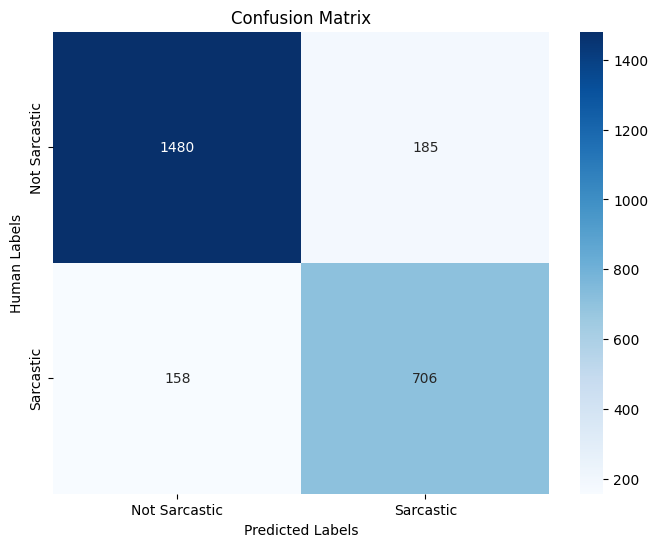

In [13]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Load the true labels and predictions
true_labels_df = pd.read_excel(r"/content/erdem_tagged.xlsx", sheet_name ="Sarcasm")  # Replace with your file
predicted_labels_df = pd.read_excel(r"/content/df_sarcasm_test_with_predictions.xlsx")  # Replace with your file

# Ensure both datasets have a common column to match (e.g., 'entry_text' or 'id')
# Merge the data on the common column (e.g., 'entry_text')
merged_df = pd.merge(true_labels_df, predicted_labels_df, on='entry_text')

# Assuming columns 'label' (true label) and 'predicted_label' (predicted label)
true_labels = merged_df['label']
predicted_labels = merged_df['predicted_label']

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Display a detailed classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Create a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted Labels')
plt.ylabel('Human Labels')
plt.title('Confusion Matrix')
plt.show()

In [23]:
df_sarcasm_test = pd.read_excel(r"/content/filtered_ekşi_sozluk_traditional_ml.xlsx")

# predict on test set
test_texts = df_sarcasm_test['processed_text'].values

df_sarcasm_test['processed_text'] = df_sarcasm_test['processed_text'].fillna("")
test_texts = df_sarcasm_test['processed_text'].astype(str).values

# 1. Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-uncased')

# 2. Tokenize the data
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)

# 3. Create a Dataset object for the test set
test_dataset = SarcasmDataset(test_encodings, labels=np.zeros(len(test_texts)))

# 4. Load the trained model
model = BertForSequenceClassification.from_pretrained(r"/content/bert-turkish-sarcasm-checkpoints_new/checkpoint-1764")

# 5. Create a Trainer
trainer = Trainer(model)

# 6. Predict on the test set
predictions = trainer.predict(test_dataset)

# 7. Extract the predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# 8. Save the predictions to a CSV file
df_sarcasm_test['New_predicted_label'] = predicted_labels
df_sarcasm_test.to_excel('all_df_sarcasm_test_with_predictions.xlsx', index=False)

print("Predictions saved")


Predictions saved


In [24]:
# Load the Excel file
filtered_df = pd.read_excel(r"/content/all_df_sarcasm_test_with_predictions.xlsx")

# Convert entry_date to period (monthly)
filtered_df['entry_date'] = pd.to_datetime(filtered_df['entry_date']).dt.to_period('M')

# Group by new_predicted_label, topic, and entry_date, and count the entries
grouped_df = filtered_df.groupby(['New_predicted_label', 'topic', 'entry_date']).size().reset_index(name='count')

# Filter the grouped data where New_predicted_label is 1
filtered_grouped_df = grouped_df[grouped_df['New_predicted_label'] == 1]

# Sort entry_date to avoid x-axis issues
filtered_grouped_df = filtered_grouped_df.sort_values(by='entry_date')

# Get unique topics for plotting
unique_filtered_topics = filtered_grouped_df['topic'].unique()

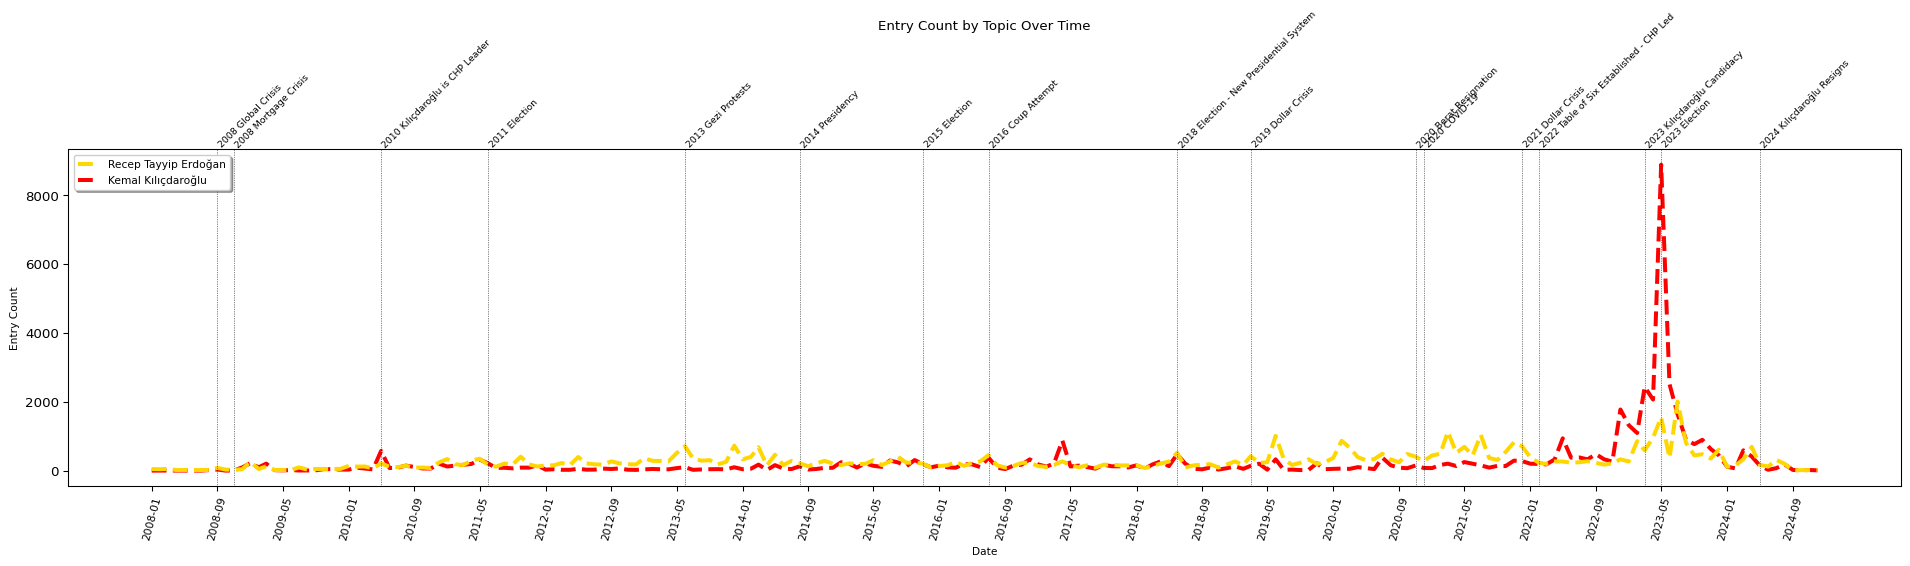

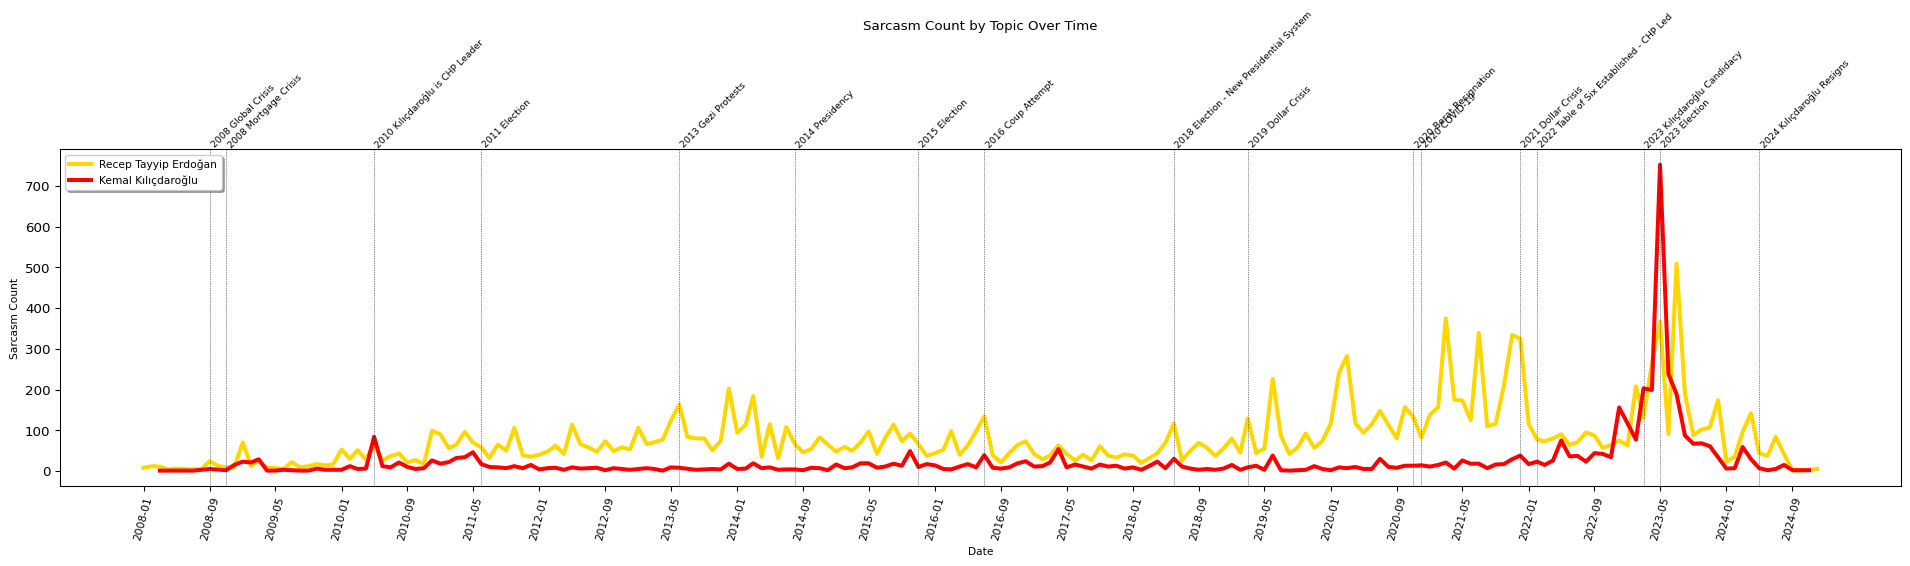

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
df = pd.read_excel(r"/content/all_df_sarcasm_test_with_predictions.xlsx")

start_date = 2008
end_date = 2025

significant_dates = {
    '2008-09': '2008 Global Crisis',      # Küresel ekonomik kriz
    '2008-11': '2008 Mortgage Crisis',    # Mortgage krizi sonrası dalgalanma
    '2010-05': '2010 Kılıçdaroğlu is CHP Leader',  # Kemal Kılıçdaroğlu became leader of the Republican People's Party (CHP)
    '2011-06': '2011 Election',           # AK Parti'nin %50 oy aldığı seçim
    '2013-06': '2013 Gezi Protests',      # Gezi Parkı olayları
    '2014-08': '2014 Presidency',         # İlk doğrudan cumhurbaşkanlığı seçimi
    '2015-11': '2015 Election',           # Kasım seçimleri, siyasi kriz sonrası
    '2016-07': '2016 Coup Attempt',       # 15 Temmuz darbe girişimi
    '2018-06': '2018 Election - New Presidential System',  # Cumhurbaşkanlığı Hükümet Sistemi'nin ilk seçimi
    '2019-03': '2019 Dollar Crisis',      # Dolar/TL dalgalanmaları ve ekonomik sıkıntılar
    '2020-11': '2020 Berat Resignation',  # Berat Albayrak'ın istifası
    '2020-12': '2020 COVID-19',           # COVID-19 pandemisi
    '2021-12': '2021 Dollar Crisis',      # Kur şoku ve dolar/TL rekor seviyeleri
    '2022-02': '2022 Table of Six Established - CHP Led', # 6'lı masa kuruldu
    '2023-03': '2023 Kılıçdaroğlu Candidacy', # Kılıçdaroğlu adaylığı açıklandı
    '2023-05': '2023 Election',           # Cumhurbaşkanlığı ve parlamento seçimleri
    '2024-05': '2024 Kılıçdaroğlu Resigns'     # Expected or possible resignation after the 2023 elections
}

# Filter significant dates to include only those within the range of the dataframe
significant_dates = {date: event for date, event in significant_dates.items() if start_date <= pd.to_datetime(date).year <= end_date}

# Filter data to get only entries with year > 2005
df = df[(pd.to_datetime(df['entry_date']).dt.year >= start_date) & (pd.to_datetime(df['entry_date']).dt.year <= end_date)]


# Convert entry_date to period (monthly) and sort by entry_date
df['entry_date'] = pd.to_datetime(df['entry_date']).dt.to_period('M')
df = df.sort_values(by='entry_date')

# Group by entry_date and topic, and count the number of entries
grouped_df = df.groupby(['entry_date', 'topic']).size().reset_index(name='count')

# Ensure entry_date is ordered and converted to datetime for plotting
grouped_df['entry_date'] = grouped_df['entry_date'].dt.to_timestamp()

# Define the color map
color_map = {
    'recep tayyip erdoğan': '#FFD700',  # Koyu sarı
    'kemal kılıçdaroğlu': 'red'         # Kırmızı
}

# Create a figure for entry count
plt.figure(figsize=(20, 6), dpi=96)  # 10 inches by 5 inches, 96 DPI

# Plot entry count
for topic in grouped_df['topic'].unique():
    topic_df = grouped_df[grouped_df['topic'] == topic]
    plt.plot(topic_df['entry_date'], topic_df['count'], linestyle='--', color=color_map.get(topic, 'blue'), label=topic, linewidth=3)

plt.xlabel('Date', fontsize=8)
plt.ylabel('Entry Count', fontsize=8)
plt.title('Entry Count by Topic Over Time', fontsize=10,pad=90)

# Limit the number of x-axis labels (tick reduction)
x_dates = grouped_df['entry_date'].unique()
num_ticks = 25
plt.xticks(ticks=x_dates[::max(1, len(x_dates) // num_ticks)], labels=[date.strftime('%Y-%m') for date in x_dates[::max(1, len(x_dates) // num_ticks)]], rotation=75, fontsize=8)

# Add significant dates to the plot
for significant_date, event in significant_dates.items():
    date = pd.to_datetime(significant_date)
    plt.axvline(x=date, color='k', linestyle=':', linewidth=0.5)
    plt.text(date, plt.ylim()[1], event, rotation=45, verticalalignment='bottom', fontsize=7)

# Custom legend order
handles, labels = plt.gca().get_legend_handles_labels()
order = [labels.index(label) for label in ['recep tayyip erdoğan', 'kemal kılıçdaroğlu'] if label in labels]
plt.legend([handles[idx] for idx in order], ['Recep Tayyip Erdoğan', 'Kemal Kılıçdaroğlu'], loc='upper left', frameon=True, shadow=True, fontsize=8)

# Save the figure
plt.tight_layout()
plt.savefig('entry_count_plot.png', dpi=300)
plt.show()

# Create sarcasm count data (assuming sarcasm predictions are stored in a column named 'New_predicted_label')
grouped_label_df = df[df['New_predicted_label'] == 1].groupby(['entry_date', 'topic']).size().reset_index(name='count')
grouped_label_df['entry_date'] = grouped_label_df['entry_date'].dt.to_timestamp()

# Create a figure for sarcasm count
plt.figure(figsize=(20, 6), dpi=96)  # 10 inches by 5 inches, 96 DPI

# Plot sarcasm count
for topic in grouped_label_df['topic'].unique():
    topic_df = grouped_label_df[grouped_label_df['topic'] == topic]
    plt.plot(topic_df['entry_date'], topic_df['count'], linestyle='-', color=color_map.get(topic, 'blue'), label=topic, linewidth=3)

plt.xlabel('Date', fontsize=8)
plt.ylabel('Sarcasm Count', fontsize=8)
plt.title('Sarcasm Count by Topic Over Time', fontsize=10,pad=90)

plt.xticks(ticks=x_dates[::max(1, len(x_dates) // num_ticks)], labels=[date.strftime('%Y-%m') for date in x_dates[::max(1, len(x_dates) // num_ticks)]], rotation=75, fontsize=8)

# Add significant dates to the plot
for significant_date, event in significant_dates.items():
    date = pd.to_datetime(significant_date)
    plt.axvline(x=date, color='k', linestyle=':', linewidth=0.5)
    plt.text(date, plt.ylim()[1], event, rotation=45, verticalalignment='bottom', fontsize=7)

# Custom legend order
handles, labels = plt.gca().get_legend_handles_labels()
order = [labels.index(label) for label in ['recep tayyip erdoğan', 'kemal kılıçdaroğlu'] if label in labels]
plt.legend([handles[idx] for idx in order], ['Recep Tayyip Erdoğan', 'Kemal Kılıçdaroğlu'], loc='upper left', frameon=True, shadow=True, fontsize=8)

# Save the figure
plt.tight_layout()
plt.savefig('sarcasm_count_plot.png', dpi=300)
plt.show()



Summary Statistics by Topic:
                      Total Entries  Sarcastic Entries  Sarcasm Percentage
topic                                                                     
kemal kılıçdaroğlu            50108               4632                9.24
recep tayyip erdoğan          56158              16157               28.77

Total number of entries: 106266
Total number of sarcastic entries: 20789
Overall sarcasm percentage: 19.56%


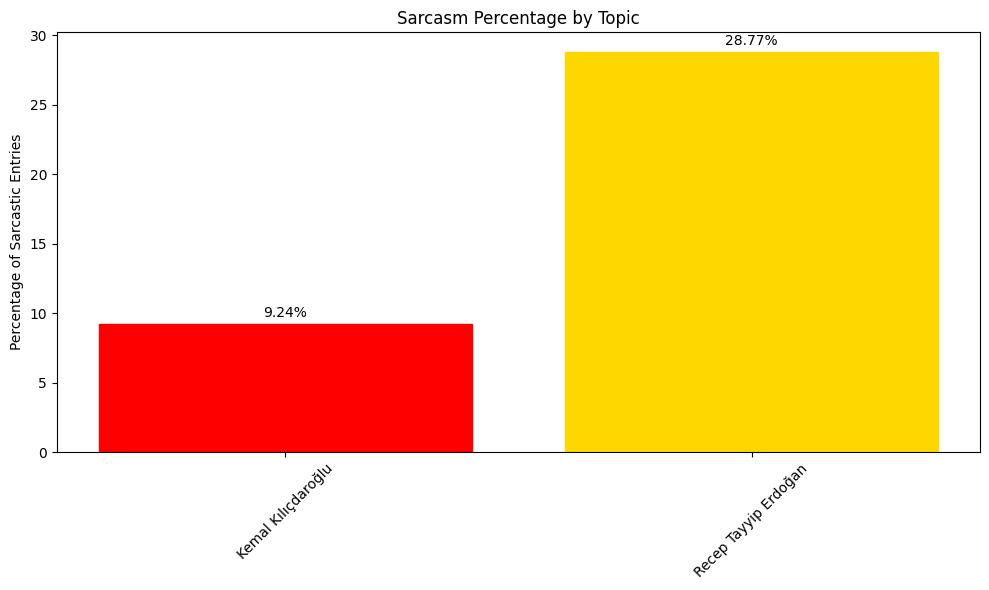

In [35]:

# Group by topic to get total entries
topic_totals = df.groupby('topic').size()

# Group by topic and count sarcastic entries (New_predicted_label == 1)
sarcasm_totals = df[df['New_predicted_label'] == 1].groupby('topic').size()

# Calculate percentage of sarcastic entries per topic
sarcasm_percentages = (sarcasm_totals / topic_totals * 100).round(2)

# Create summary table
summary_df = pd.DataFrame({
    'Total Entries': topic_totals,
    'Sarcastic Entries': sarcasm_totals,
    'Sarcasm Percentage': sarcasm_percentages
})

print("\nSummary Statistics by Topic:")
print(summary_df)

print("\nTotal number of entries:", len(df))
print("Total number of sarcastic entries:", df['New_predicted_label'].sum())
print("Overall sarcasm percentage: {:.2f}%".format(df['New_predicted_label'].mean() * 100))
# Create a bar plot
plt.figure(figsize=(10, 6))

# Plot bars for each topic
bars = plt.bar(summary_df.index, summary_df['Sarcasm Percentage'])

# Customize bar colors
for i, bar in enumerate(bars):
    if summary_df.index[i] == 'recep tayyip erdoğan':
        bar.set_color('#FFD700')  # Gold
    else:
        bar.set_color('red')

# Add value labels on top of bars
for i, v in enumerate(summary_df['Sarcasm Percentage']):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center')

# Customize the plot
plt.title('Sarcasm Percentage by Topic')
plt.ylabel('Percentage of Sarcastic Entries')
plt.xticks(range(len(summary_df.index)), [name.title() for name in summary_df.index], rotation=45)

# Adjust layout and display
plt.tight_layout()
plt.show()